# GEOG696C Spatiotemporal Data Analytics: Term Project
## extractPixelFIATimeSeries.ipynb
This script extracts time series of fractional inundated area (FIA) per pixel from the Giezendanner et al. (2023) dataset of historical flooding. I create time series of weekly FIA for each 500 m pixel, before aggregating to monthly, seasonal and annual time steps.

In [4]:
from pathlib import Path
import os
import sys
import pandas as pd
# import geopandas as gpd
import numpy as np
import rasterio as rio
from rasterio.plot import show
from rasterio.mask import mask
# import rioxarray
# import xarray
# from shapely.geometry import Polygon
# from shapely.geometry import Point
# import matplotlib.pyplot as plt
# from itertools import chain
from datetime import datetime, timezone

In [7]:
# Set the root path
rootPath = Path('/media/mule/Projects/NASA/NIP/Data')

## 1) Get the rasters with the FIA data

In [23]:
# dataPath = rootPath/'Models/DeepLearning/Inference/CrossValidation/Archive/Historical/Ensemble'
dataPath = Path('C:/Users/alexsaunders/Documents/01_uoa/02_ra/01_projects/01_nip/02_hysteresis/inTmp') # local copy
dataFiles = [file for file in list(dataPath.iterdir()) if file.suffix=='.tiff']

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/alexsaunders/Documents/01_uoa/02_ra/01_projects/01_nip/02_hysteresis/inTmp'

In [13]:
print(len(dataFiles))

985


## 2) Open raster and get number of pixels

In [14]:
file = dataFiles[0]

In [15]:
file

PosixPath('/media/mule/Projects/NASA/NIP/Data/Models/DeepLearning/Inference/CrossValidation/Archive/Historical/Ensemble/1210550400000.tiff')

In [16]:
# Get the data of the image
imageDate=datetime.fromtimestamp(int(file.stem[:-3])).strftime('%Y%m%d')

In [17]:
imageDate

'20080511'

In [18]:
raster = rio.open(file)

In [22]:
rasterData = raster.read(1)

In [24]:
rasterData

array([[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       ...,
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.]],
      dtype=float32)

## PART 3: Get the mean, median and 5/95%ile FIA values for all ROIs

In [25]:
# Set the output path
# outputPath = rootPath/'Table/AllGaugesFracFloodedAreaFusion/15km'
outputPath = Path('C:/Users/alexsaunders/Documents/01_uoa/02_ra/01_projects/01_nip/02_hysteresis/outTmp/upazillas')
outputPath.mkdir(exist_ok=True)

# Loop through the tif files
for f, fusionFile in enumerate(fusionFiles):
    
    # Map date
    ImageDate=datetime.fromtimestamp(int(fusionFile.stem[:-3])).strftime('%Y%m%d')

    # Create an empty list for saving results
    results = []

    # Loop through geometries
    for i, targetGeom in enumerate(rois_gdf['geometry']):

        print(f, str(ImageDate), ':', str(rois_gdf.loc[i,'id']), 'roi', i+1, 'of', len(rois_gdf), end='\r')

        # Get the FIA values for the file and get stats
        with rioxarray.open_rasterio(fusionFile).rio.clip([targetGeom]) as clipRaster: # opens raster and clip to roi

            # Get a list of all valid pixel values, ignoring / remove nodata values
            FIAVals = clipRaster.values[np.logical_and(clipRaster.values>=0, clipRaster.values<=1)]

            if len(FIAVals)>0:
                FIAStats =[np.mean(FIAVals),
                np.median(FIAVals),
                np.std(FIAVals),
                np.quantile(FIAVals, 0.05),
                np.quantile(FIAVals, 0.95)]
            else:
                FIAStats =[np.nan, np.nan, np.nan, np.nan, np.nan]

        # Append results to dataframe      
        result = [rois_gdf.loc[i,'id']] + FIAStats
        results.append(result)

    # Save the df for each date  
    FIAStatsDF = pd.DataFrame(results, columns=['ROI','MeanFIA','MedianFIA','StdevFIA','05PctFIA','95PctFIA'])
    FIAStatsDF.to_csv(outputPath/('FIA_Fusion_allUpazillas_{0}.csv'.format(str(ImageDate))), index=False)

## Repeat for coordinate locations in the SFSA farmer response data

In [5]:
sfsaPath = Path('C:/Users/alexsaunders/Documents/01_uoa/04_git/dissertation/data/sfsa')
file = 'Bangladesh SFSA Flood Focus Group data.xlsx'
data = pd.read_excel(sfsaPath/file, sheet_name='SFSA Flood Focus Group Form')

In [46]:
# Get columns with GPS in the name
gpsCols = [i for i, item in enumerate(data.columns) if 'GPS' in item][1:]
geogCols=[14,15,16,17,18]
keepCols=gpsCols+geogCols
sfsaLocs = data.iloc[:, keepCols]
sfsaLocs.columns=['lat','lon']+list(sfsaLocs.columns[2:])

In [47]:
sfsaLocs

,lat,lon,_GPS location of product pilot area_altitude,_GPS location of product pilot area_precision,Division,District,Sub-district,Union,Village
0,25.274000,89.285600,0,0.000000,Rangpur,Gaibandha,Sadullapur,Kamarpara,Uttor had bamni
1,24.415700,89.294000,0,0.000000,Rajshahi,Bogra,Sherpur,Khamerkhandi,Jajor
2,25.263400,89.285700,0,0.000000,Rangpur,Gaibandha,Sadullapur,Damodurpur,Purbodamodurpur
3,25.192000,89.231500,0,0.000000,Rangpur,Gaibandha,Sadullapur,Edilpur,Edilpur
4,24.394100,89.294600,0,0.000000,Rajshahi,Bogra,Sherpur,Khanpur,Chawbaria
5,25.254500,89.255100,0,0.000000,Rangpur,Gaibandha,Sadullapur,Jamalpur,Sreekola
6,25.283300,89.274100,0,0.000000,Rangpur,Gaibandha,Sadullapur,Noldangga,Jorgasvita
7,25.272700,89.264000,0,0.000000,Rangpur,Gaibandha,Sadullapur,Rosulpur,Kajipara
8,24.523500,89.342300,0,0.000000,Rajshahi,Bogra,Sariakandi,Sariakhandi Sador,Digalkandi
9,24.512800,89.343200,0,0.000000,Rajshahi,Bogra,Sariakandi,Kutuppur,Pardavdana


In [48]:
# Create geopandas df of the coordinate points
geometry = [Point(xy) for xy in zip(sfsaLocs['lon'], sfsaLocs['lat'])]
sfsa_gdf = gpd.GeoDataFrame(sfsaLocs, geometry=geometry, crs='epsg:4326')
sfsa_gdf

,lat,lon,_GPS location of product pilot area_altitude,_GPS location of product pilot area_precision,Division,District,Sub-district,Union,Village,geometry
0,25.274000,89.285600,0,0.000000,Rangpur,Gaibandha,Sadullapur,Kamarpara,Uttor had bamni,POINT (89.28560 25.27400)
1,24.415700,89.294000,0,0.000000,Rajshahi,Bogra,Sherpur,Khamerkhandi,Jajor,POINT (89.29400 24.41570)
2,25.263400,89.285700,0,0.000000,Rangpur,Gaibandha,Sadullapur,Damodurpur,Purbodamodurpur,POINT (89.28570 25.26340)
3,25.192000,89.231500,0,0.000000,Rangpur,Gaibandha,Sadullapur,Edilpur,Edilpur,POINT (89.23150 25.19200)
4,24.394100,89.294600,0,0.000000,Rajshahi,Bogra,Sherpur,Khanpur,Chawbaria,POINT (89.29460 24.39410)
5,25.254500,89.255100,0,0.000000,Rangpur,Gaibandha,Sadullapur,Jamalpur,Sreekola,POINT (89.25510 25.25450)
6,25.283300,89.274100,0,0.000000,Rangpur,Gaibandha,Sadullapur,Noldangga,Jorgasvita,POINT (89.27410 25.28330)
7,25.272700,89.264000,0,0.000000,Rangpur,Gaibandha,Sadullapur,Rosulpur,Kajipara,POINT (89.26400 25.27270)
8,24.523500,89.342300,0,0.000000,Rajshahi,Bogra,Sariakandi,Sariakhandi Sador,Digalkandi,POINT (89.34230 24.52350)
9,24.512800,89.343200,0,0.000000,Rajshahi,Bogra,Sariakandi,Kutuppur,Pardavdana,POINT (89.34320 24.51280)


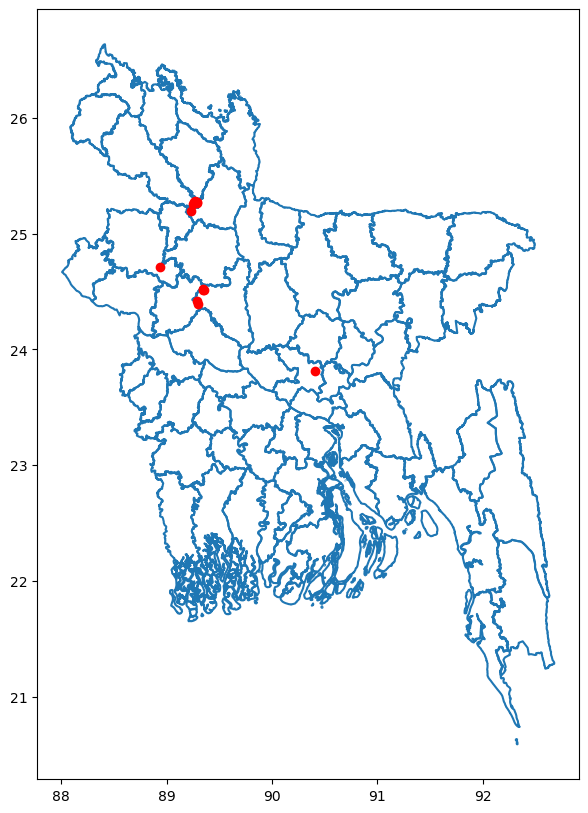

In [49]:
# Quick plot of the coords

fig, ax = plt.subplots(figsize=(10,10))

districts.boundary.plot(ax=ax)
sfsa_gdf.plot(ax=ax, color='red', zorder=2)

plt.show()

#### Two locations with low GPS precision - look not right on the map! Do not use these

In [51]:
sfsa_gdf=sfsa_gdf.iloc[0:11, :]

In [64]:
# Create buffer around the coordinate geometries
locGeoms = sfsa_gdf.geometry
buffer_sizes = [15] # 0.5
pd.options.mode.chained_assignment = None  # default='warn'

for buffer_size in buffer_sizes:
    
    # Add new field to locs geodataframe to store the buffer geometries
    sfsa_gdf['buffer_'+str(buffer_size)] = 0

    # For each gaugeLoc, get the buffer and add back to the geodataframe
    for i in range(0, len(sfsa_gdf)):
        locGeom = locGeoms[i]
        buffer = analyse_DV.geodesic_point_buffer(locGeom.y, locGeom.x, buffer_size) # lat, lon, buffer (in km)
        sfsa_gdf['buffer_'+str(buffer_size)][i] = Polygon(buffer)
        
# loc_list = list(chain.from_iterable([list(list(sfsa_gdf.index)+'_'+str(buffer_size)+'km') for buffer_size in buffer_sizes]))
# loc_geom_list = list(chain.from_iterable([list(sfsa_gdf['buffer_'+str(buffer_size)]) for buffer_size in buffer_sizes]))

# Create a single geodataframe of ROIs over which to calculate FFA
rois = {'id': list(sfsa_gdf.index), 
        'geometry': sfsa_gdf['buffer_'+str(buffer_sizes[0])]}
rois_gdf = gpd.GeoDataFrame(rois, geometry='geometry', crs='epsg:4326')

In [65]:
rois_gdf

,id,geometry
0,0,"POLYGON ((89.43452 25.27392, 89.43379 25.26065..."
1,1,"POLYGON ((89.44190 24.41563, 89.44117 24.40235..."
2,2,"POLYGON ((89.43461 25.26332, 89.43387 25.25005..."
3,3,"POLYGON ((89.38032 25.19193, 89.37959 25.17865..."
4,4,"POLYGON ((89.44247 24.39403, 89.44174 24.38075..."
5,5,"POLYGON ((89.40400 25.25442, 89.40326 25.24115..."
6,6,"POLYGON ((89.42303 25.28322, 89.42230 25.26995..."
7,7,"POLYGON ((89.41292 25.27262, 89.41219 25.25935..."
8,8,"POLYGON ((89.49032 24.52343, 89.48959 24.51015..."
9,9,"POLYGON ((89.49121 24.51273, 89.49048 24.49945..."


In [67]:
# Set the output path
# outputPath = rootPath/'Table/AllGaugesFracFloodedAreaFusion/15km'
outputPath = Path('C:/Users/alexsaunders/Documents/01_uoa/02_ra/01_projects/01_nip/02_hysteresis/outTmp/sfsaLocs15km')
outputPath.mkdir(exist_ok=True)

# Loop through the tif files
for f, fusionFile in enumerate(fusionFiles):
    
    # Map date
    ImageDate=datetime.fromtimestamp(int(fusionFile.stem[:-3])).strftime('%Y%m%d')

    # Create an empty list for saving results
    results = []

    # Loop through geometries
    for i, targetGeom in enumerate(rois_gdf['geometry']):

        print(f, str(ImageDate), ':', str(rois_gdf.loc[i,'id']), 'roi', i+1, 'of', len(rois_gdf), end='\r')

        # Get the FIA values for the file and get stats
        with rioxarray.open_rasterio(fusionFile).rio.clip([targetGeom]) as clipRaster: # opens raster and clip to roi

            # Get a list of all valid pixel values, ignoring / remove nodata values
            FIAVals = clipRaster.values[np.logical_and(clipRaster.values>=0, clipRaster.values<=1)]

            if len(FIAVals)>0:
                FIAStats =[np.mean(FIAVals),
                np.median(FIAVals),
                np.std(FIAVals),
                np.quantile(FIAVals, 0.05),
                np.quantile(FIAVals, 0.95)]
            else:
                FIAStats =[np.nan, np.nan, np.nan, np.nan, np.nan]

        # Append results to dataframe      
        result = [rois_gdf.loc[i,'id']] + FIAStats
        results.append(result)

    # Save the df for each date  
    FIAStatsDF = pd.DataFrame(results, columns=['ROI','MeanFIA','MedianFIA','StdevFIA','05PctFIA','95PctFIA'])
    FIAStatsDF.to_csv(outputPath/('FIA_Fusion_sfsaLocs_{0}.csv'.format(str(ImageDate))), index=False)